### TODO:
* make input arguements into a dictionary (possibly accept as commandline arguments)
* adjust code to use the `PorousMaterials.jl` function `isotherm_sim_results_to_dataframe` instead of defining it as a function in this script.
* Explicitly define the adsorption scale factor (it has to do with adsorption/unitcell, change in unit cell?)

# JLD2 to CSV
This script convets `.jld2` files output from `PorousMaterials.jl`'s ` muVT_simulation` function and compiles them into a `.csv` file which can then be imported into a DataFrame.

In [1]:
using PorousMaterials
using FileIO
using JLD2
using CSV
using DataFrames
using PyPlot
using PyCall

# PyPlot.matplotlib.style.use("Solarize_Light2")
PyPlot.matplotlib.style.use("ggplot")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16; #16;

In [2]:
set_path_to_data(joinpath(pwd(), "..", "data"))

# @eval PorousMaterials PATH_TO_DATA = joinpath(pwd(), "..", "data")
# @eval PorousMaterials PATH_TO_FORCEFIELDS = joinpath(PATH_TO_DATA, "forcefields")
# @eval PorousMaterials PATH_TO_MOLECULES = joinpath(PATH_TO_DATA, "molecules")
# @eval PorousMaterials PATH_TO_CRYSTALS = joinpath(PATH_TO_DATA, "crystals")
# @eval PorousMaterials PATH_TO_SIMS = joinpath(PATH_TO_DATA, "simulations")

general data folder: /home/ng/DTRA/simulated_isotherm_data/../data
	crystal structures (.cif, .cssr): /home/ng/DTRA/simulated_isotherm_data/../data/crystals
	force field files (.csv): /home/ng/DTRA/simulated_isotherm_data/../data/forcefields
	molecule input files: /home/ng/DTRA/simulated_isotherm_data/../data/molecules
	simulation output files: /home/ng/DTRA/simulated_isotherm_data/../data/simulations
	grids (.cube): /home/ng/DTRA/simulated_isotherm_data/../data/grids


In [3]:
# whtat properties do you want to put into the .csv?
props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]

adsorbates = ["Xe", "Kr", "Ar"]

pmin = -2 # minimum pessure in log10, units: bar
pmax = 1.1 # maximum pressure (actual value), units: bar
nstep = 25 # number of intervals in pressure range

sim_params = Dict("adsorbates" => adsorbates,
                  "temp"       => 298.0, # units: K
                  "molecules"  => Dict(zip(adsorbates, Molecule.(adsorbates))),
                  "pressures"  => 10 .^ range(pmin, stop=log10(pmax), length=nstep),
                  "ljff"       => LJForceField("UFF"),
                  "n_burn"     => 50000,
                  "n_sample"   => 50000
                  )

Dict{String, Any} with 7 entries:
  "adsorbates" => ["Xe", "Kr", "Ar"]
  "ljff"       => Force field: UFF…
  "n_burn"     => 50000
  "pressures"  => [0.01, 0.0121635, 0.014795, 0.0179959, 0.0218893, 0.026625, 0…
  "temp"       => 298.0
  "molecules"  => Dict{String, Molecule{Cart}}("Kr"=>Molecule species: Kr…
  "n_sample"   => 50000

### Dictionaries useful for plotting

In [4]:
### WHAT THINGS DO I NEED TO BE ABLE TO DISTINGUISH BETWEEN? ###
# 1. Different Adsorbates:
#    - each gets it's own color -> adsorbate_to_color
# 2. Different Materials (depending on the plot)
#    - each material gets its own marker and/or color
# 3. Different Types of Data (experimental vs. simulation)
#    - each type gets its own line style (scatter vs solid line)
#
# Each of these categories has a set of lables
###


# we want to assign a specific marker to each crystal
#     NOTE: marker="v","D" is reserved for experimental data
mof_to_marker = Dict(zip(adsorbates, ["P", "2", "x", "o", "*", ">"]))

# we want to assign a specific adsorbate to a color
adsorbate_to_color = Dict(zip(adsorbates, ["C0", "C1", "C2"]))

label_data_type = Dict("exp" => Dict(zip(adsorbates, adsorbates .* " experiment")), 
                       "sim" => Dict(zip(adsorbates, adsorbates .* " simulation")))

exp_data_to_marker = Dict(zip(adsorbates, ["v", "D"]))
exp_data_to_color = Dict(zip(adsorbates, ["g", "b"]))

markers = [".", "o", "v", "^", ">", "<", "1", "2", "3", "4", "8", "s", "p", "P", 
            "*", "h", "H", "+", "x", "X", "D", "d"]

mof_to_marker = Dict(zip(frameworks, ["P", "2", "x", "o", "*", ">"]))
mof_to_color = Dict(zip(frameworks, ["C$i" for i = 1:length(frameworks)]))



LoadError: UndefVarError: frameworks not defined

## Import experimental data

In [5]:
function experimental_isotherm_data(adsorbate::String, fgroup::String="")
    # define data file name
    filename = "NiPyC2" 
    if ! isempty(fgroup)
        filename *= "-" * fgroup
    end
    filename *= "_" * adsorbate * "_T_298.csv"
    @info filename
    # define path to data file
    wheres_exptl_data = joinpath(PorousMaterials.PATH_TO_DATA,
        "experimental_isotherm_data", filename)
    # read data file into a DataFrame
    df_exptl_data = CSV.read(wheres_exptl_data, DataFrame)
    # rename to adsorption column for consistency 
    rename!(df_exptl_data, Symbol("loading (mmol/g)") => Symbol("⟨N⟩ (mmol/g)"))
    # ignore desortion
    desorp_onset = argmax(df_exptl_data[!, Symbol("pressure (bar)")]) # onset of desorption
    df_exptl_data = df_exptl_data[1:desorp_onset, [Symbol("pressure (bar)"), Symbol("⟨N⟩ (mmol/g)")]]
    # add a point at the origin
    push!(df_exptl_data, [0.0, 0.0])
    # 3 sort in order of increasing pressure
    sort!(df_exptl_data, Symbol("pressure (bar)"))
    return df_exptl_data
end

experimental_isotherm_data (generic function with 2 methods)

## Import simulated data 

In [6]:
function read_sim_data(props::Array{String, 1}, framework::Crystal, 
                        gas::Molecule{Cart}, temp::Float64, ffield::LJForceField, 
                        pressure::Array{Float64}, nburn::Int64, nsample::Int64)
    press = [[p] for p in pressures]
    df_sim = isotherm_sim_results_to_dataframe(props, xtal, [mol], temp, press, ljff, nburn, nsample)
    push!(df_sim, [[0.0], [0.0], [0.0]]) ### add point at origin ###
    sort(df_sim, Symbol("pressure (bar)"))
    return df_sim
end
# create a second method that is easier to implement
function read_sim_data(props::Array{String, 1}, gas::String, params::Dict{String, Any})
    @assert (gas in params["adsorbates"])
    gas = Molecule(gas)
    return read_sim_data(props, params["xtal"], gas, params["temp"],
                         params["ljff"], params["pressures"], params["n_burn"], params["n_sample"])
end

read_sim_data (generic function with 2 methods)

In [7]:
function adsorption_scale_factor(mof::String)
    xtal = Crystal(mof)
    strip_numbers_from_atom_labels!(xtal)
#         @assert length(frameworks) == 1
    adsorption_scale_factor = 6.02214 * crystal_density(xtal) * xtal.box.Ω * 10^(-7)
    return adsorption_scale_factor
end

adsorption_scale_factor (generic function with 1 method)

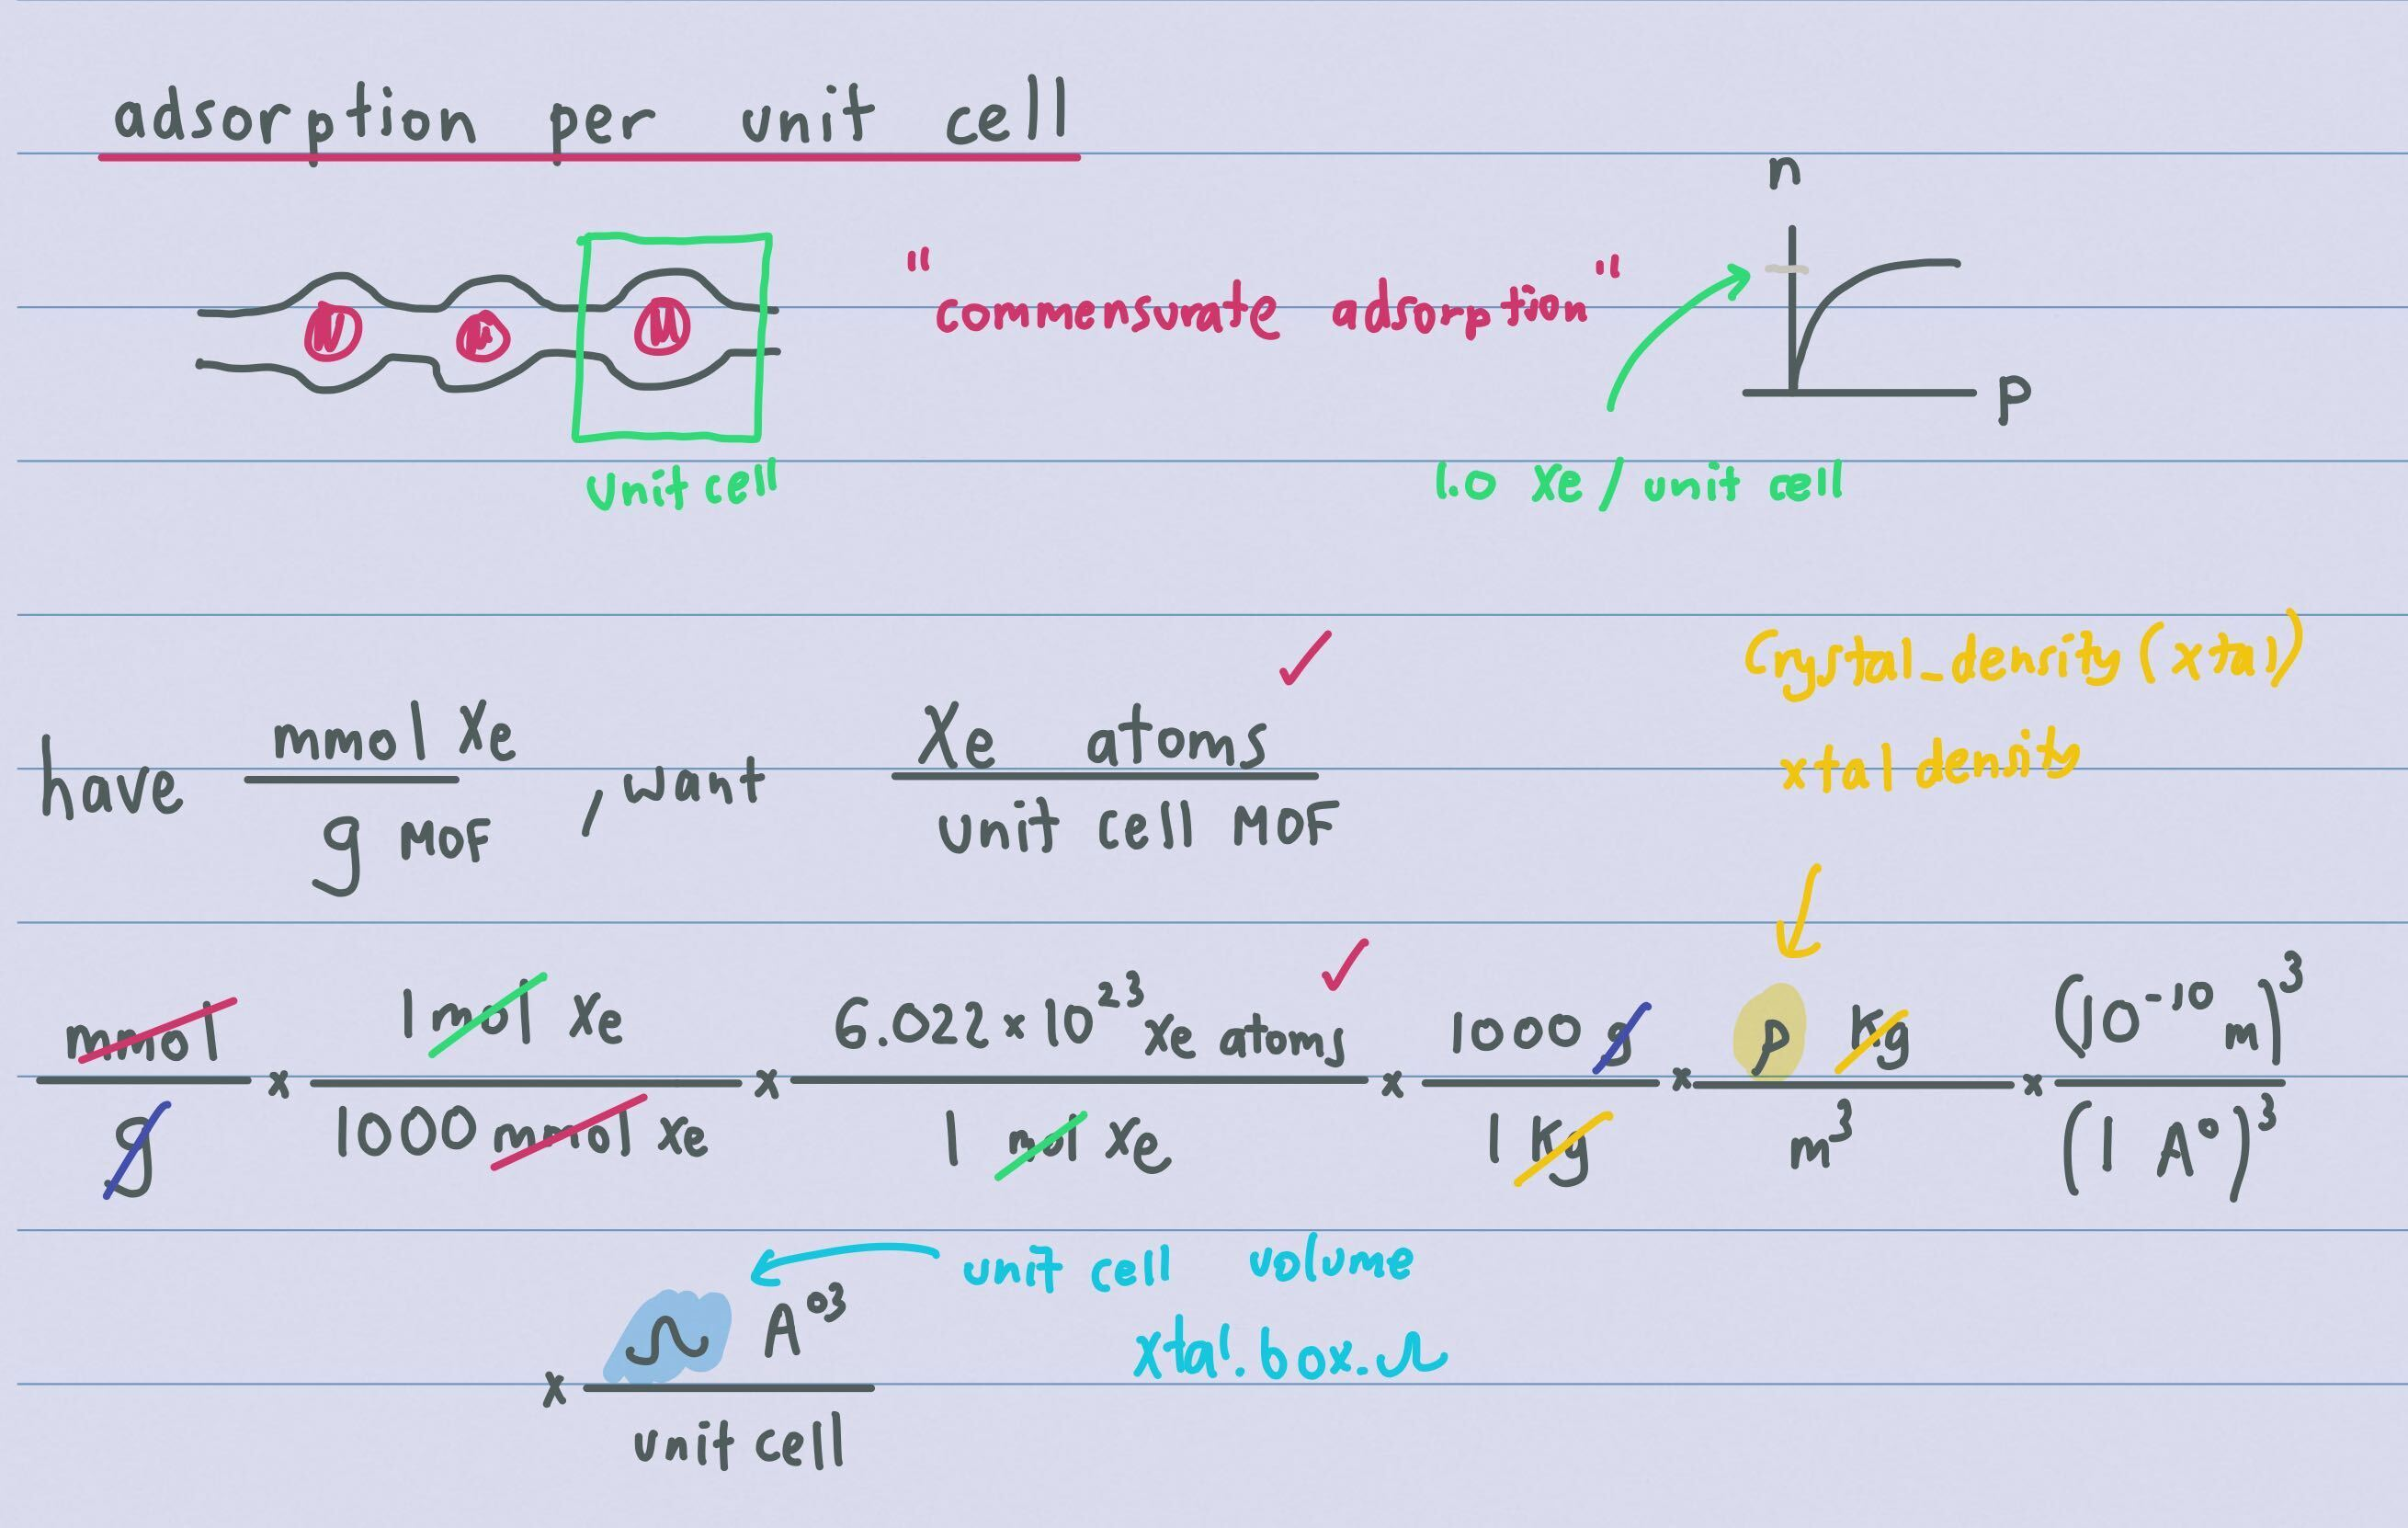

## Plot data

In [8]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(PATH_TO_DATA, "crystals")
frameworks = ["NiPyC2_experiment.cif", 
              "NiPyC2_relax.cif",
              "NiPyC2_vc-relax.cif", 
              "NiPyC2_pbesol-angle-vc-relax.cif",
              "NiPyC2_vdw-df2_relax.cif",
              "NiPyC2_vdw-df2_vc-relax.cif"]


labels_mof = Dict(zip(frameworks, [L"NiPyC$_2$", 
                                   L"NiPyC$_2$, pbesol relax",
                                   L"NiPyC$_2$, pbesol vc-relax", 
                                   L"NiPyC$_2$, pbesol angle-vc-relax",
                                   L"NiPyC$_2$, vdw relax",
                                   L"NiPyC$_2$, vdw vc-relax"]))

adsorption_per_unit_cell = false
ads_scale_factor = 1.0

if adsorption_per_unit_cell
    ads_scale_factor = adsorption_scale_factor(frameworks[1])
    xtal = Crystal(frameworks[1])
    strip_numbers_from_atom_labels!(xtal)
#     @assert length(frameworks) == 1
#     adsorption_scale_factor = 6.02214 * crystal_density(xtal) * xtal.box.Ω * 10^(-7)
end

###
# make figure
###
figure()
for gas in adsorbate
    for mof in frameworks
        df_sim = read_sim_data(props_we_want, mof, gas, temp, ffield, pressures, nburn, nsample)
        plot(df_sim[:, Symbol("pressure (bar)")], 
                df_sim[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
                label=labels_gas[gas] * ", " * labels_mof[mof], 
                marker=mof_to_marker[mof],
                color=mof_to_color[mof])
    end
    df_exp = experimental_isotherm_data(gas, "")
    scatter(df_exp[:, Symbol("pressure (bar)")], 
            df_exp[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
            label=labels_exp[gas] * ", " * L"NiPyC$_2$", 
            marker=exp_data_to_marker[gas], 
            color=adsorbate_to_color[gas])
end

legend(loc="best", fontsize="xx-small", title="T = 298 K")
xlabel("pressure [bar]")
if adsorption_per_unit_cell
    ylabel("uptake [atoms/unit cell]")
else
    ylabel("uptake [mmol/g]")
    
end
# title(L"Ni(PyC)$_2$ experiment vs. simulation (UFF)")
# title("NiPyC2 isotherms with $ffield")
# xlim(xmin=0, xmax=1.2)
# ylim(ymin=0, ymax=4.0)
grid("on")
tight_layout()
# savefig("NiPyC2_DFT_isotherms_with_$ffield.pdf", dpi=300, format="pdf")
# savefig("NiPyC2_isotherms_uptake_per_unit_cell_with_$ffield.pdf", dpi=300, format="pdf")

LoadError: UndefVarError: adsorbate not defined

### Plot: Experimental vs Simulated Results for Functionalized and Parent MOFs 

In [9]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath("/home/ng/DTRA/structural_relaxation/post-relaxation_cifs/")

# add simulated isotherm of experimental structure
frameworks = ["NiPyC2_experiment.cif",
                "NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif",
                "NiPyC2_relax_sc211_ortho_functionalized_NH2_pbesol_relax.cif"]


# pretty labels for each MOF
labels_mof = Dict(zip(frameworks, [L"Ni(PyC)_2", L"m-NH_2, pbesol", L"o-NH_2, pbesol"]))
mof_to_marker = Dict(zip(frameworks, ["P", "2", "x", "o", "*", ">"]))
mof_to_color = Dict(zip(frameworks, ["C$i" for i = 1:length(frameworks)]))

# prety labels for each experimental data set
labels_exp = Dict("Xe" => "Xe experiment", "Kr" => "Kr experiment")
exp_data_to_marker = Dict(zip(["", "NH2"], ["v", "D"]))
exp_data_to_color = Dict(zip(["", "NH2"], ["g", "b"]))

# labels for adsorbate used
labels_gas = Dict("Xe" => "Xe simulation", "Kr" => "Kr simulation")

###
# adsorption per unit cell
###
adsorption_per_unit_cell = false
ads_scale_factor = 1.0

###
# Create Figure
###
figure()

for gas in adsorbate
    # plot results for xtal given an adsorbate 
    for mof in frameworks
        # calculate adsorption_scale_factor if needed
        if adsorption_per_unit_cell
            ads_scale_factor = adsorption_scale_factor(mof)
            if occursin("NH2", mof)
                ads_scale_factor /= 2
                @warn "dividing adsorption_scale_factor by a factor of 2 componsate for replication factors"
            end
        end
        
        # get and plot simulation results
        df_sim = read_sim_data(props_we_want, mof, gas, temp, ffield, pressures, nburn, nsample)
        plot(df_sim[:, Symbol("pressure (bar)")], 
                df_sim[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
                label=labels_gas[gas] * ", " * labels_mof[mof], 
                marker=mof_to_marker[mof],
                color=mof_to_color[mof])
    end
    
    # get and plot experimental results
    for fgroup in ["", "NH2"]
        if adsorption_per_unit_cell
            if fgroup == ""
                ads_scale_factor = adsorption_scale_factor("NiPyC2_experiment.cif") 
            elseif fgroup == "NH2"
                ads_scale_factor = 
                        adsorption_scale_factor("NiPyC2_relax_sc211_ortho_functionalized_NH2_pbesol_relax.cif") / 2
            else
                @error "No adsorption_scale_factor determined for experimental structure"
            end
        end
        @info fgroup
        fg_name = Dict(zip(["", "NH2"], ["", L"NH_2"]))
        df_exp = experimental_isotherm_data(gas, fgroup)
        scatter(df_exp[:, Symbol("pressure (bar)")], 
                df_exp[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
                label=labels_exp[gas] * ", " * L"Ni(PyC)$_2$ " * fg_name[fgroup] , 
                marker=exp_data_to_marker[fgroup], 
                color=exp_data_to_color[fgroup])
    end
end

grid("on")
legend(loc="best", fontsize="xx-small") 
xlabel("pressure [bar]")
title(L"Ni(PyC)$_2$ simulation vs. experiment")

# if adsorption_per_unit_cell
#     ylabel("uptake [atoms/unit cell]")
#     tight_layout()
#     savefig("NH2_isotherms_uptake_per_cell_with_UFF.pdf", dpi=300, format="pdf")
# else
#     ylabel("uptake [mmol/g]")
#     tight_layout()
#     savefig("NH2_isotherms_with_UFF.pdf", dpi=300, format="pdf")
# end

LoadError: UndefVarError: adsorbate not defined

### multi-axis adsorption isotherm plot

*TODO:*
- put 298 K inside legend box
- label dashed line with "2 atoms/unit cell"
- make dashed line for Kr and label?
- change markers and colors to be independent for each isotherm

In [10]:
# @eval PorousMaterials PATH_TO_CRYSTALS = joinpath("/home/ng/DTRA/structural_relaxation/post-relaxation_cifs/")
set_path_to_data(joinpath(pwd(), "..", "data"))


# frameworks to plot
frameworks = ["NiPyC2_experiment.cif"]
labels_mof = Dict(zip(frameworks, ["Ni(PyC)"*L"_2"]))

adsorbate_to_color = Dict(zip(adsorbates, ["C0", "C1", "C2"]))
adsorbate_to_marker = Dict(zip(["Xe", "Kr", "Ar"], ["v", "D", "h"]))

data_marker = Dict(zip([1, 2, 3, 4, 5],["", "X", "v", "P", "D"]))

# labels for each MOF
mof_to_marker = Dict(zip(frameworks, ["x", "s", "P", "o", "*", ">"]))
# mof_to_color = Dict(zip(frameworks, ["C$i" for i = 1:length(frameworks)]))

# labels for each experimental data set
labels_exp = Dict("Xe" => "Xe experiment", "Kr" => "Kr experiment") #  => "Xe experiment"
exp_data_to_marker = Dict(zip(["", "NH2"], ["v", "D"]))
exp_data_to_color = Dict(zip(["", "NH2"], ["g", "b"]))

# labels for adsorbate used
labels_gas = Dict("Xe" => "Xe simulation", "Kr" => "Kr simulation", "Ar" => "Ar simulation")

general data folder: /home/ng/DTRA/simulated_isotherm_data/../data
	crystal structures (.cif, .cssr): /home/ng/DTRA/simulated_isotherm_data/../data/crystals
	force field files (.csv): /home/ng/DTRA/simulated_isotherm_data/../data/forcefields
	molecule input files: /home/ng/DTRA/simulated_isotherm_data/../data/molecules
	simulation output files: /home/ng/DTRA/simulated_isotherm_data/../data/simulations
	grids (.cube): /home/ng/DTRA/simulated_isotherm_data/../data/grids


Dict{String, String} with 3 entries:
  "Kr" => "Kr simulation"
  "Ar" => "Ar simulation"
  "Xe" => "Xe simulation"

In [11]:
###
# Create Figure
###
fig, ax1 = plt.subplots() # create the figure as a subplot

# create an array for plot handles
plts = Array{Any, 1}(undef, 5)
nn = 1

# create an empty plot object to place T=298 K in legend
# plts[nn] = ax1.scatter([], [], label="T = 298 K", marker=data_marker[nn], color="")


########
sim_params["xtal"] = Crystal(frameworks[1])

for gas in adsorbates
    for mof in frameworks
        # increment plot index
        nn += 1 

        # load in simulation data
        df_sim = read_sim_data(props_we_want, gas, sim_params)
        
        # plot uptake mmol/g 
        plts[nn] = ax1.plot(df_sim[:, Symbol("pressure (bar)")], 
                            df_sim[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_gas[gas],
                            marker=data_marker[nn],
                            markersize=8,
                            markeredgecolor="black",
                            markeredgewidth=0.1,
                            color=adsorbate_to_color[gas],
                            clip_on=false)
    end
    # increment plot index
    nn += 1 
    
    # reset ads_scale_factor
    ads_scale_factor = 1.0 
    
    # load exptl data
    df_exp = experimental_isotherm_data(gas) # default fgroup=""
    # plot exptl data
    plts[nn] = ax1.scatter(df_exp[:, Symbol("pressure (bar)")], 
                            df_exp[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
                            label=labels_exp[gas],
                            marker=data_marker[nn],
                            color=adsorbate_to_color[gas],
                            clip_on=false)
end

ads_scale_factor = adsorption_scale_factor(frameworks[1])


# title(L"Ni(PyC)$_2$ simulation vs. experiment")
# ["T = 298 K", "Xe simulation", "Xe experiment", "Kr simulation", "Kr experiment"],
# legend((plts[1], plts[2][1], plts[3], plts[4][1], plts[5]),
#             ["T = 298 K", "Xe simulation", "Xe experiment", "Kr simulation", "Kr experiment"],
#             loc="lower right", fontsize="xx-small") 

legend(title="T = 298 K", loc="lower right", fontsize="xx-small")

ax1.grid("on")
ax1.set_xlabel("pressure [bar]")
ax1.set_ylabel("uptake [mmol/g]")

ymin = -0.04
ymax = 4
ax1.set_ylim(ymin, ymax)


xmin = -0.01
xmax = pressures[end] + 0.01
ax1.set_xlim(xmin, xmax)

ax1.axhline(y=2/ads_scale_factor, linestyle="--", color="0.4")
ax1.text(0.02, 2/ads_scale_factor+0.04, "2 adsorbates/unit cell", color="0.4", fontsize=9)

tight_layout()
# savefig("NiPyC2_isotherms_sim_vs_exp_UFF.pdf", dpi=300, format="pdf")

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/ng/.julia/dev/PorousMaterials/src/crystal.jl:426


LoadError: UndefVarError: pressures not defined